In [167]:
import pandas as pd
import numpy as np
import warnings
from matplotlib import pyplot as plt

warnings.filterwarnings("ignore")

### 1. Скачайте данные в формате csv

In [154]:
data_path = 'https://covid.ourworldindata.org/data/owid-covid-data.csv'
days_delta = 50
date_start = '2020-03-03'
date_end = '2020-12-03'


In [155]:
df = pd.read_csv(data_path)

In [156]:
df = df[df['iso_code'] == 'RUS']
df['date'] = pd.to_datetime(df['date'])
df = df[df['date'] >= date_start]
df = df[df['date'] <= date_end]
# df = df[df['date'] < df['date'].min() + pd.Timedelta(days=days_delta)]
df.reset_index(drop=True, inplace=True)

In [196]:
target_col = ['total_cases'] # 'total_cases', new_cases
feature_cols = [
    'total_deaths',
    'new_deaths',
    'new_deaths_smoothed',
    'stringency_index',
    'reproduction_rate',
    'total_tests',
    'new_tests',
    'new_tests_smoothed',
    'positive_rate',
    'tests_per_case',
]

In [197]:
X = df[feature_cols]
y = df[target_col]
# y[y == 0] = 1

X_train = X[:days_delta]
y_train = y[:days_delta]

X_test = X[days_delta:]
y_test = y[days_delta:]

In [198]:
X['total_deaths'].fillna(0, inplace=True)
X['new_tests_smoothed'].fillna(0, inplace=True)
X['positive_rate'].fillna(0, inplace=True)
X['tests_per_case'].fillna(0, inplace=True)
X['reproduction_rate'].fillna(X['reproduction_rate'].mean(), inplace=True)
X['total_tests'].interpolate(method='nearest', inplace=True)
X['total_tests'].fillna(X['total_tests'].min(), inplace=True)
X['new_tests'].interpolate(method='nearest', inplace=True)
X['new_tests'].fillna(X['new_tests'].min(), inplace=True)


In [199]:
X.isna().sum()

total_deaths           0
new_deaths             0
new_deaths_smoothed    0
stringency_index       0
reproduction_rate      0
total_tests            0
new_tests              0
new_tests_smoothed     0
positive_rate          0
tests_per_case         0
dtype: int64

In [200]:
X.head()

,total_deaths,new_deaths,new_deaths_smoothed,stringency_index,reproduction_rate,total_tests,new_tests,new_tests_smoothed,positive_rate,tests_per_case
0,0.0,0.0,0.0,8.33,1.21046,46414.0,2243.0,0.0,0.0,0.0
1,0.0,0.0,0.0,8.33,1.21046,46414.0,2243.0,0.0,0.0,0.0
2,0.0,0.0,0.0,16.67,1.21046,51366.0,4952.0,0.0,0.0,0.0
3,0.0,0.0,0.0,16.67,1.21046,55688.0,4322.0,0.0,0.0,0.0
4,0.0,0.0,0.0,16.67,1.21046,59960.0,4272.0,0.0,0.0,0.0


### 2. Постройте графики целевых переменных

<AxesSubplot:title={'center':'new_cases'}>

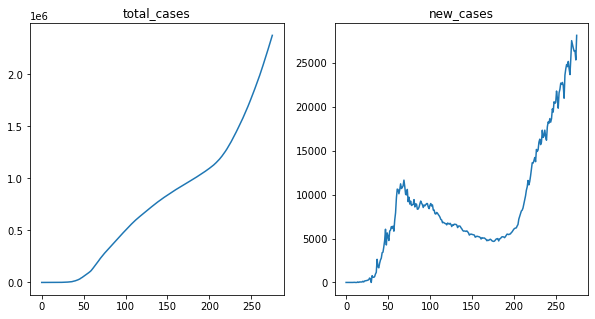

In [201]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
df['total_cases'].plot(ax=ax[0], title='total_cases')
df['new_cases'].plot(ax=ax[1], title='new_cases')

#### 2.a линейная регрессия с экспоненциальным ростом числа заболевших

In [202]:
from sklearn.linear_model import LinearRegression

In [212]:
model = LinearRegression()
model.fit(X_train, np.log(y_train))

preds_train = model.predict(X_train)
preds_test = model.predict(X_test)
preds = np.concatenate([preds_train, preds_test])
preds = np.exp(preds)

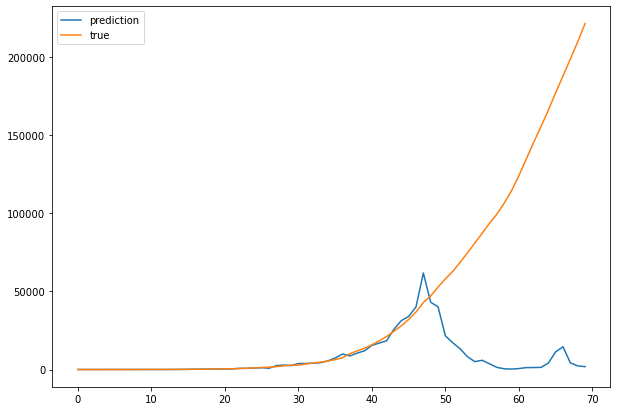

In [232]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(preds[:70], label='prediction')
ax.plot(y[:70], label='true')
ax.legend();

#### 2.b апостериорное распределение параметров модели для достаточно широкого априорного распределения
### Комментарий
Берем в качестве априорного распределения гауссиану с условно "большой" дисперсией. Далее умножаем ее на оценку правдоподобия в одной точке по формулам, которые разбирали на лекции. Полученное распределение также является гауссианой, т.к. нормальное распределение является сопряженным для линейной регрессии. Берем полученное апостерирорное распределение в качестве априорного и повторяем процедуру N-1 раз, где N - количество точек данных (в нашем случае 50)  

In [276]:
w = np.append(model.coef_[0], model.intercept_[0])
sigma_noise = (y_train - preds_train).std().values[0]
sigma_noise, w

(13555.650384664257,
 array([-7.24526900e-04,  4.77262250e-03, -1.53756856e-01,  4.42072838e-02,
         7.81853157e-01,  3.23329246e-07, -1.53285207e-06,  2.94104609e-05,
         1.94021555e+02,  4.02367436e-04, -7.38336818e-02]))

In [363]:
cur_mu, cur_sigma = np.zeros(w.shape[0]), np.eye(w.shape[0]) * 1000
cur_mu.shape, cur_sigma.shape

((11,), (11, 11))

In [364]:
def bayesian_update(mu, sigma, x, y, sigma_noise):
    x = np.concatenate((x, np.array([[1]])), axis=1)
    sigma_n = np.linalg.inv(np.linalg.inv(sigma) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x), x) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x), y))
    return mu_n, sigma_n

In [365]:
w

array([-7.24526900e-04,  4.77262250e-03, -1.53756856e-01,  4.42072838e-02,
        7.81853157e-01,  3.23329246e-07, -1.53285207e-06,  2.94104609e-05,
        1.94021555e+02,  4.02367436e-04, -7.38336818e-02])

In [366]:
for i in range(0, 50):
    cur_mu, cur_sigma = bayesian_update(cur_mu, cur_sigma, X_train.iloc[i:i+1], y_train.iloc[i], sigma_noise=sigma_noise)
cur_mu

array([ 1.23985723e+01,  8.34351919e-01,  1.06531100e+00, -6.52037431e+00,
       -3.27325333e-01,  3.64715679e-02, -8.25266257e-03, -3.77213587e-01,
        2.17279337e-04, -1.10924763e+00, -1.70884732e-01])

#### 2.c графики сэмплов разных экспонент

In [ ]:
N_SAMPLES = 500

plt.figure(figsize=(12, 5))
sampled_w = np.random.multivariate_normal(mu, sigma, N_SAMPLES)
for (w0, w1) in sampled_w:
    y_pred = X_train * w1 + w0
    plt.plot(np.exp(y_pred))
plt.plot(np.exp(y_train), color='red', linewidth=3, label='Real')
plt.legend();